# Switch to  GRU RNN & memorizing capacity

In [1]:
import os, shutil, sys, warnings, datetime
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as mp, patches as patches
from keras import backend as K, preprocessing as kpre, \
                             datasets as kdat, models as kmod, \
                             layers as klay, optimizers as kopt, \
                             utils as kutil, callbacks as kcall, \
                             initializers as kinit, activations as kact, \
                             regularizers as kreg, applications as kapp
import tensorflow as tf
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

Using TensorFlow backend.


In [3]:
jtplot.style()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## Train data import & preprocessing

In [4]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST/'
img_w = 49
img_h = 49
img_ch = 1

In [5]:
files = os.listdir(traindir)
for f in range(len(files)):
    img = cv.imread(traindir + files[f], 0)
    img = cv.resize(img, (img_w, img_h))
    img = cv.equalizeHist(img)
    if f == 0:
        x_train = np.zeros((len(files), img_h, img_w))
    x_train[f] = img

In [6]:
cap = 10
x_train0 = np.expand_dims(x_train[:cap], -1)
x_train0 = np.tile(x_train0.T, 128//cap).T

## Model setup

In [7]:
sessiondir = '{}/'.format(datetime.datetime.now().strftime('%Y%m%d'))
os.makedirs(sessiondir, exist_ok=True)
batch_size = len(x_train0)
epochs = int(1e6)

In [8]:
amrnn = kmod.Sequential(name='AMRNN')
amrnn.add(klay.Reshape(input_shape=(img_h, img_w, img_ch),
                       target_shape=(img_h, img_w),
                       name='reshape1'))
amrnn.add(klay.CuDNNGRU(units=img_h*img_w,
#                         activation='tanh',
#                         recurrent_activation='hard_sigmoid',
                        name='rnn-gru1'))
amrnn.add(klay.Dense(units=img_h*img_w,
                     activation='sigmoid',
                     name='fc1'))
amrnn.add(klay.Reshape(target_shape=(img_h, img_w, img_ch),
                       name='reshape2'))

amrnn.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape1 (Reshape)           (None, 49, 49)            0         
_________________________________________________________________
rnn-gru1 (CuDNNGRU)          (None, 2401)              17661756  
_________________________________________________________________
fc1 (Dense)                  (None, 2401)              5767202   
_________________________________________________________________
reshape2 (Reshape)           (None, 49, 49, 1)         0         
Total params: 23,428,958
Trainable params: 23,428,958
Non-trainable params: 0
_________________________________________________________________


In [9]:
class AdaBound(kopt.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
    
class StopOnValue(kcall.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(kcall.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)
            
        if current < self.value:
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True

    
def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.nn.l2_loss(y_pred - y_true)

def l1loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.losses.absolute_difference(y_true, y_pred)

def tvloss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def psnr(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def tv(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

In [10]:
# history = kcall.History()
checkpoint = kcall.ModelCheckpoint('AMRNN_best_weights.h5',
                                   save_best_only=True,
                                   monitor='loss',
                                   mode='min')
# lr_reduce = kcall.ReduceLROnPlateau(monitor='loss',
#                                     factor=0.1,
#                                     patience=2,
#                                     min_lr=1e-3,
#                                     verbose=0)
csvlogger = kcall.CSVLogger('AMRNN_training.log', 
                            separator=',', 
                            append=False)
tblog = kcall.TensorBoard(log_dir='./.tb_logs/%s/' \
                                  %(datetime.datetime.now().strftime('%Y%m%d-%H%M%S')),
                          histogram_freq=0,
                          write_graph=True,
                          embeddings_freq=0,
                          update_freq='epoch',
                          write_images=False)
# estop = EarlyStopping(monitor='loss',
#                       min_delta=1e-5,
#                       patience=10,
#                       restore_best_weights=True)
stopval = StopOnValue(monitor='loss',
                      value=0.1)

In [11]:
amrnn.compile(loss=l2loss,
              optimizer=AdaBound(lr=1e-3,
                                 final_lr=5e-4),
              metrics=[psnr, ssim])
# amrnn.load_weights('AMRNN_best_weights.h5')

W0924 15:39:22.916259 17404 deprecation_wrapper.py:119] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Model training

In [12]:
history = amrnn.fit(x_train0/255,
                    x_train0/255,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[ktqdm(), checkpoint, csvlogger, tblog, stopval])
amrnn.save('AMRNN.model')

W0924 15:39:23.617257 17404 deprecation_wrapper.py:119] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0924 15:39:23.721256 17404 deprecation_wrapper.py:119] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0924 15:39:23.802294 17404 deprecation_wrapper.py:119] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0924 15:39:29.914174 17404 deprecation_wrapper.py:119] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0924 15:39:29.916129 17404 deprecation_wrap

KeyboardInterrupt: 

In [ ]:
amrnn = kmod.load_model('AMRNN.model', custom_objects={'l2loss': l2loss,
                                                       'psnr': psnr,
                                                       'ssim': ssim,
                                                       'AdaBound': AdaBound})

In [ ]:
amrnn.load_weights('AMRNN_best_weights.h5')

# Prepare test data & show results

loss = 23262.927734375 
 psnr = 8.160202980041504 
 ssim = 0.028548937290906906


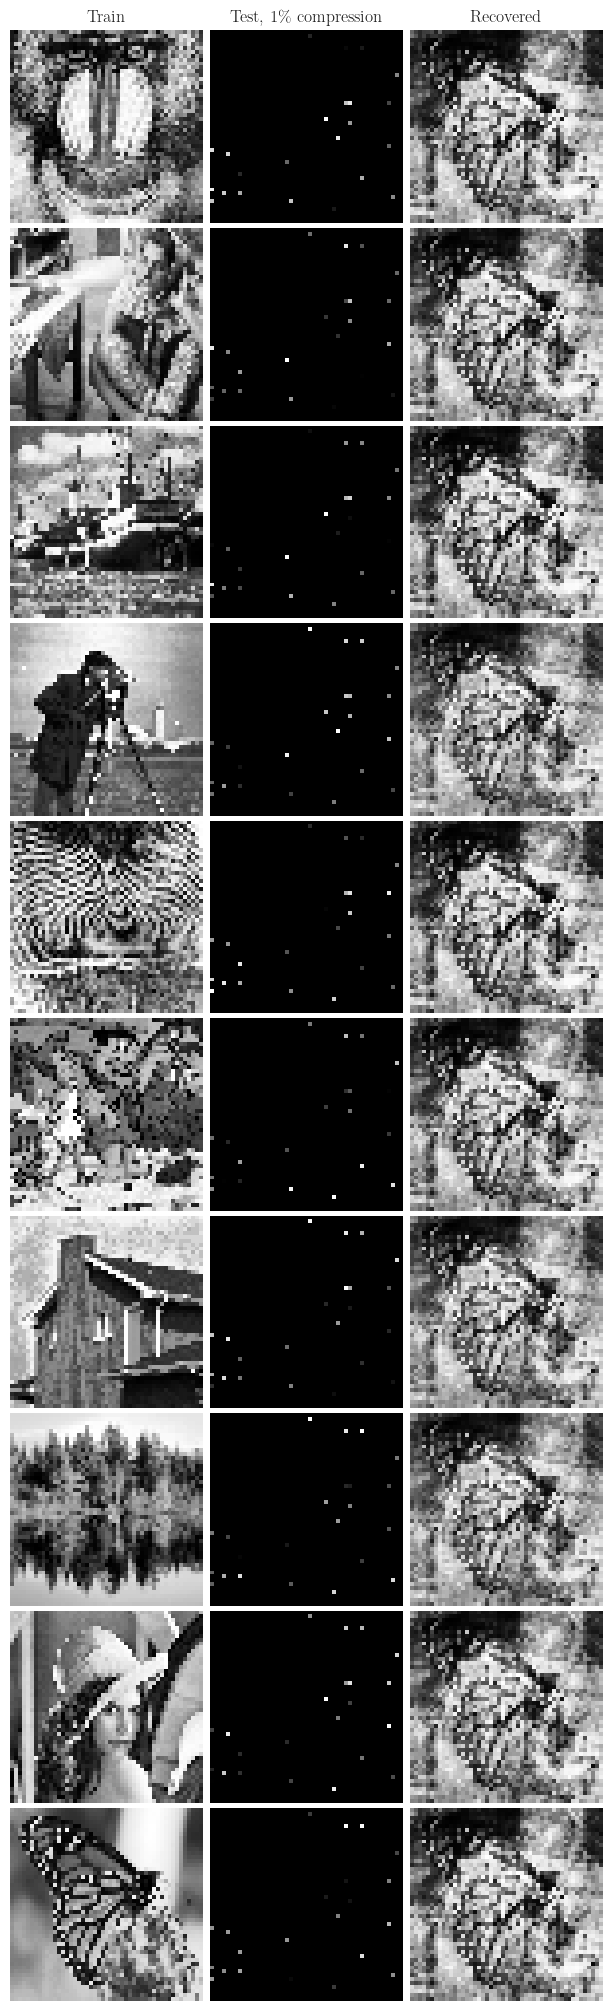

loss = 26492.396484375 
 psnr = 7.623563289642334 
 ssim = 0.018661582842469215


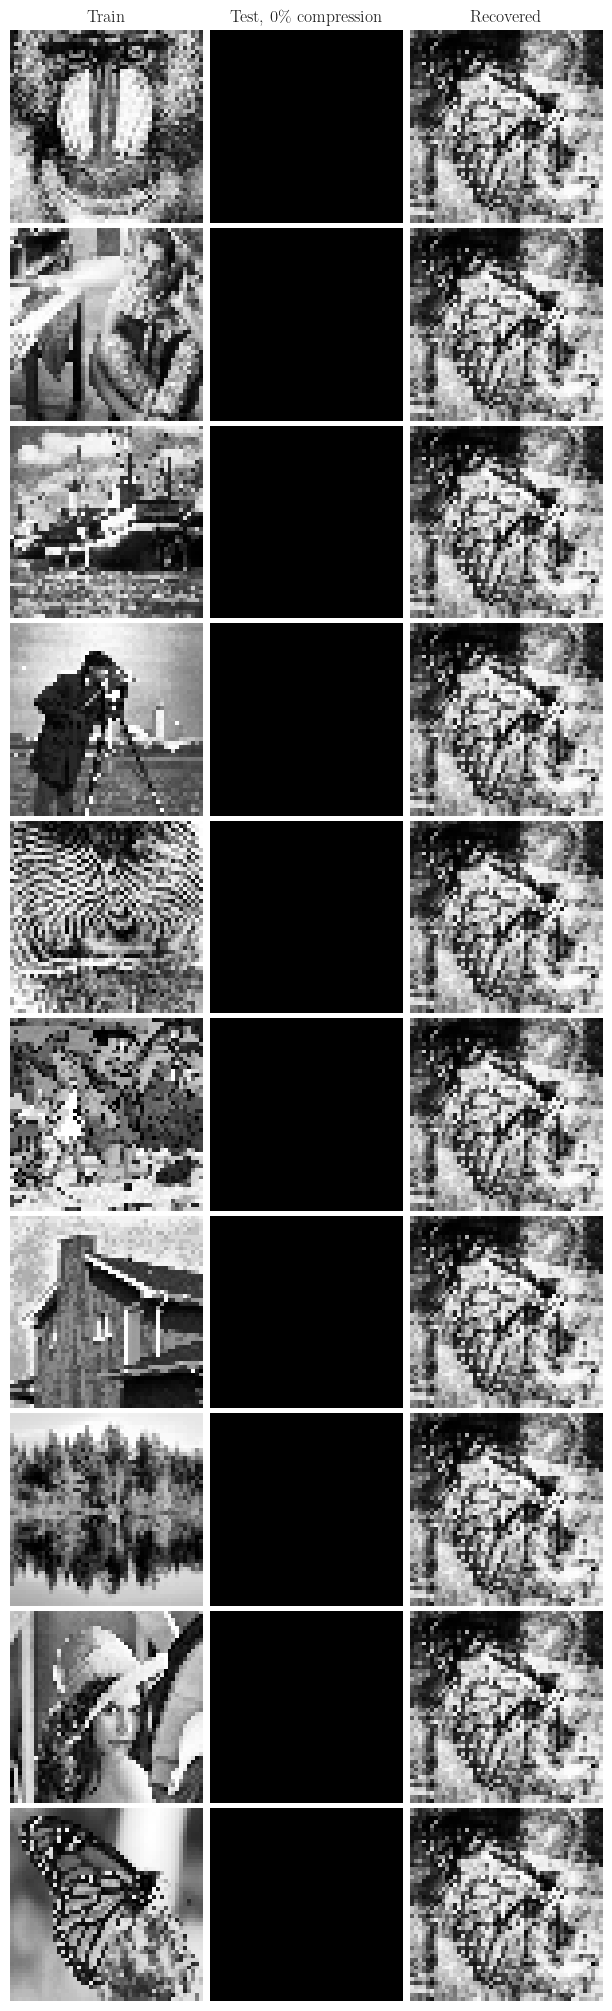

loss = 24030.685546875 
 psnr = 8.138043403625488 
 ssim = 0.06866507232189178


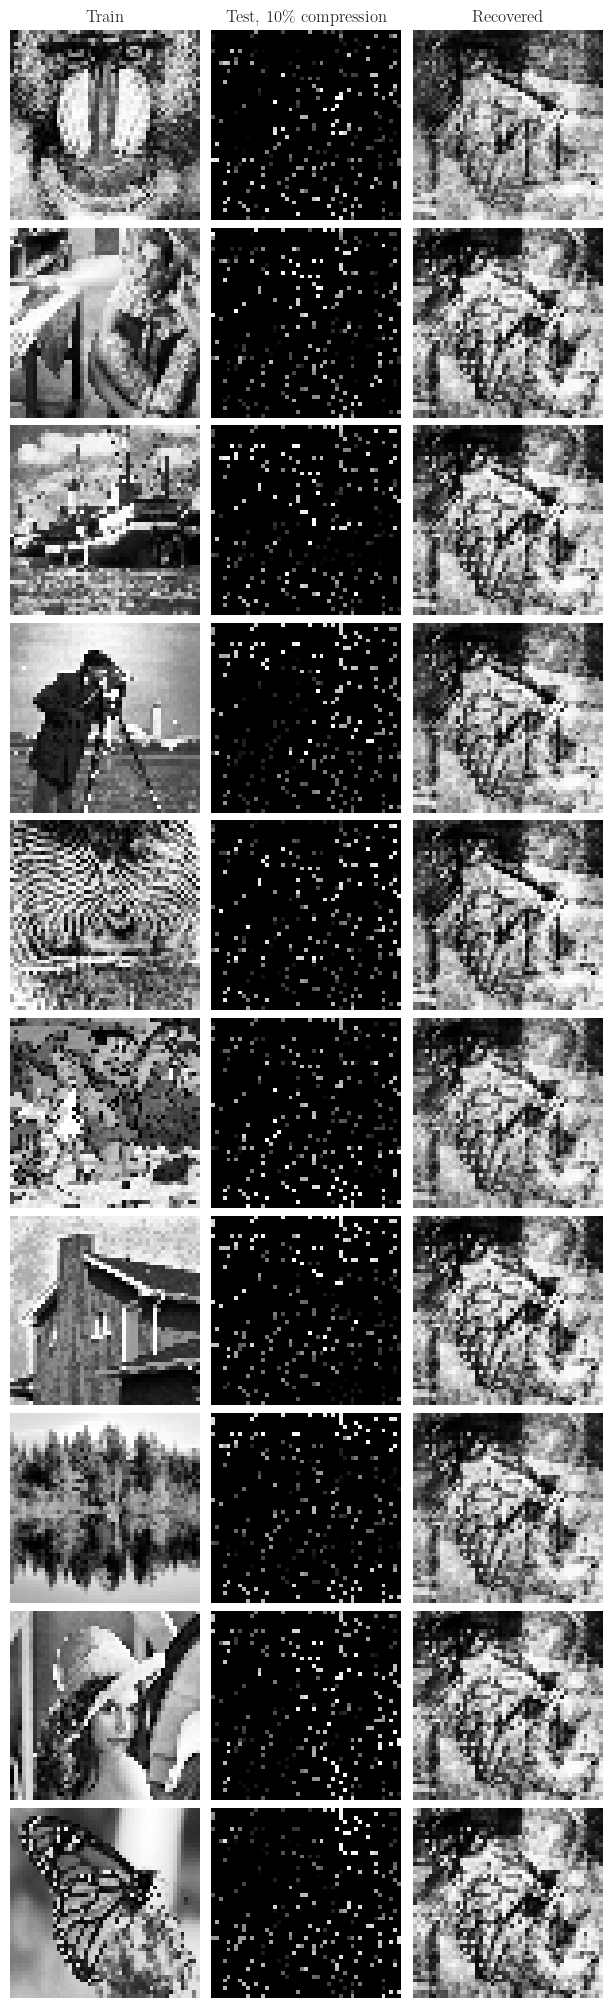

loss = 20833.349609375 
 psnr = 8.791309356689453 
 ssim = 0.11397210508584976


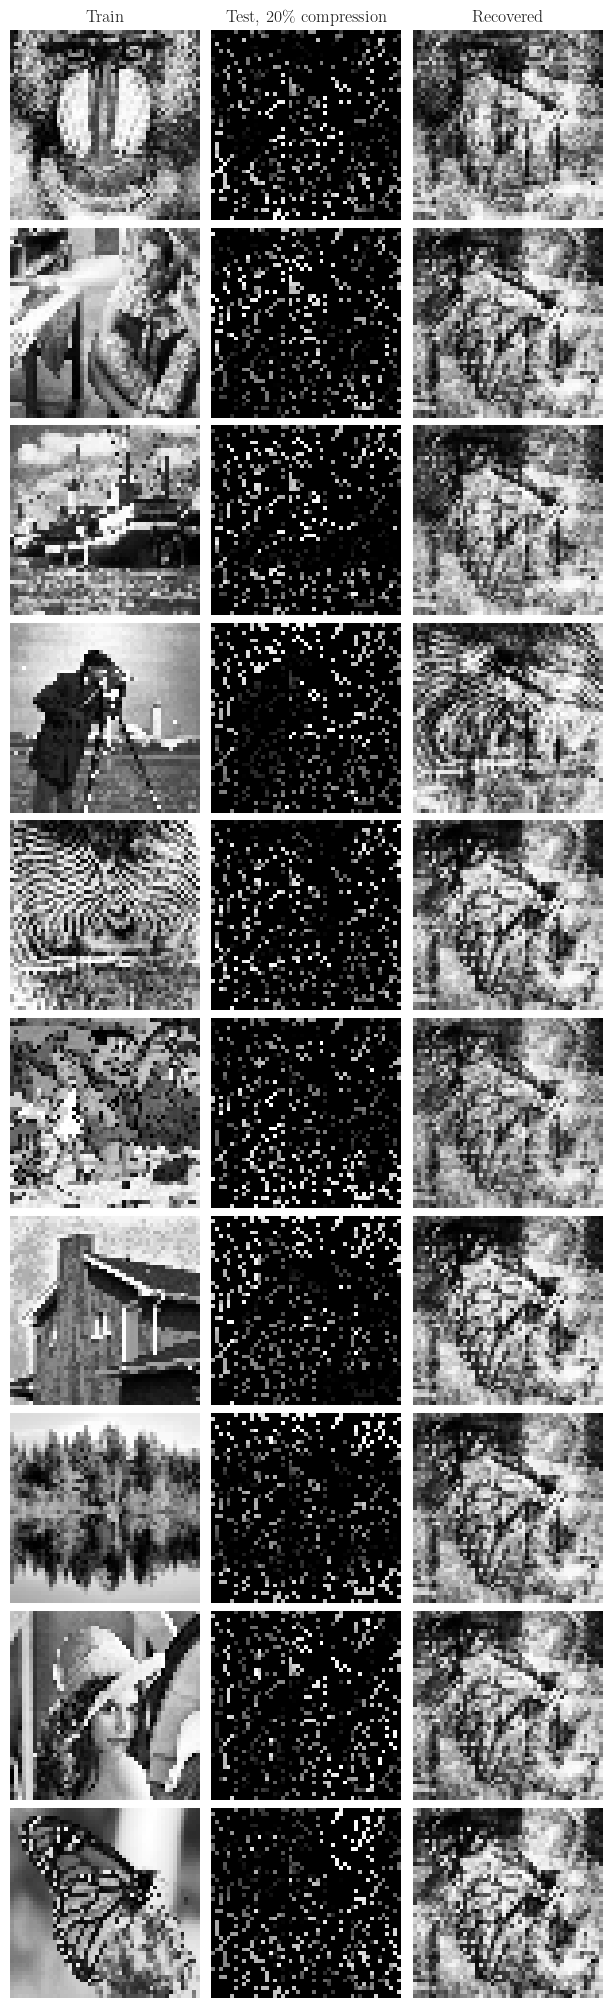

loss = 13095.134765625 
 psnr = 11.370224952697754 
 ssim = 0.3027688264846802


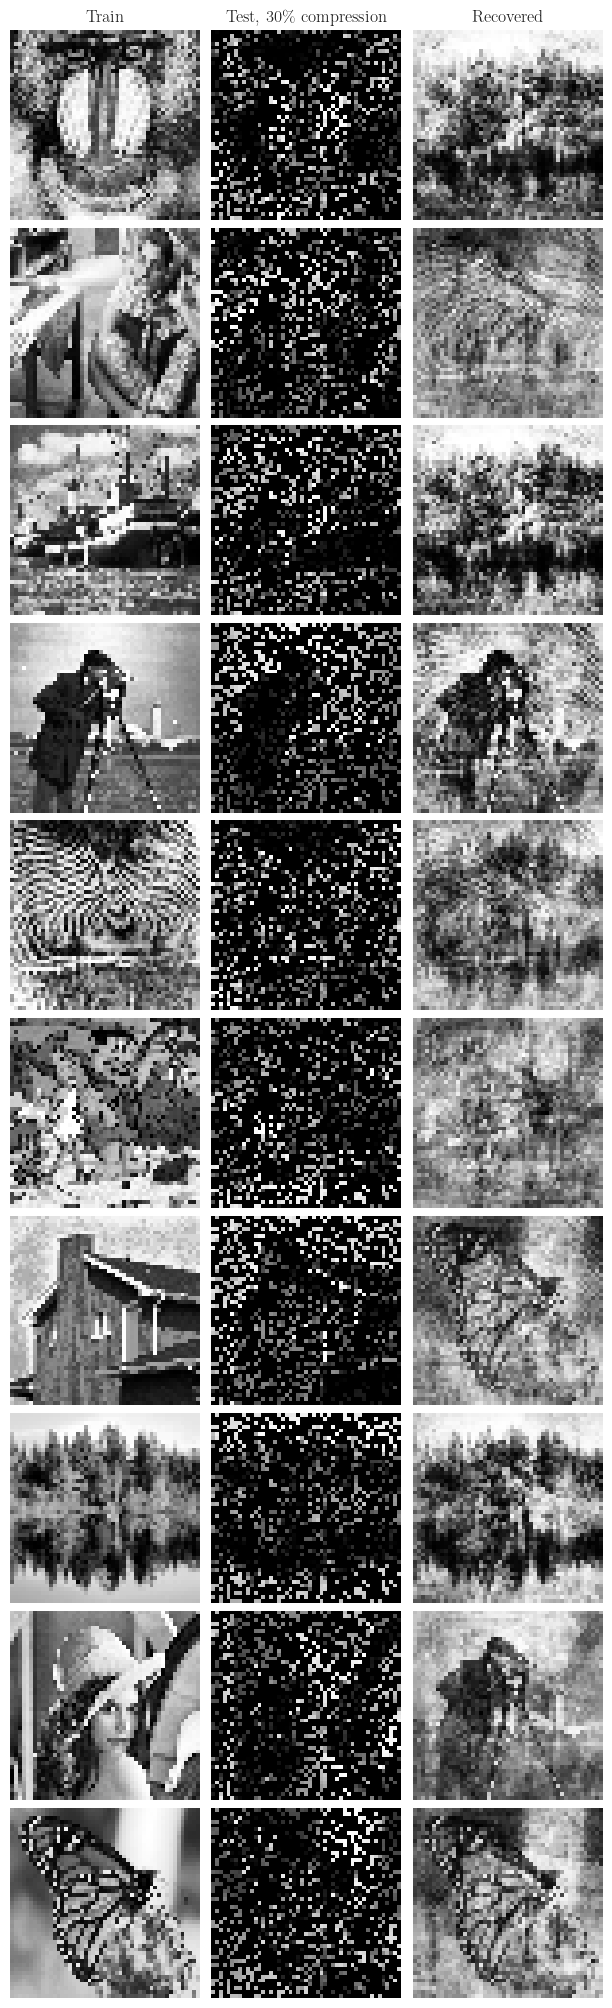

loss = 13349.83203125 
 psnr = 11.514007568359375 
 ssim = 0.33232519030570984


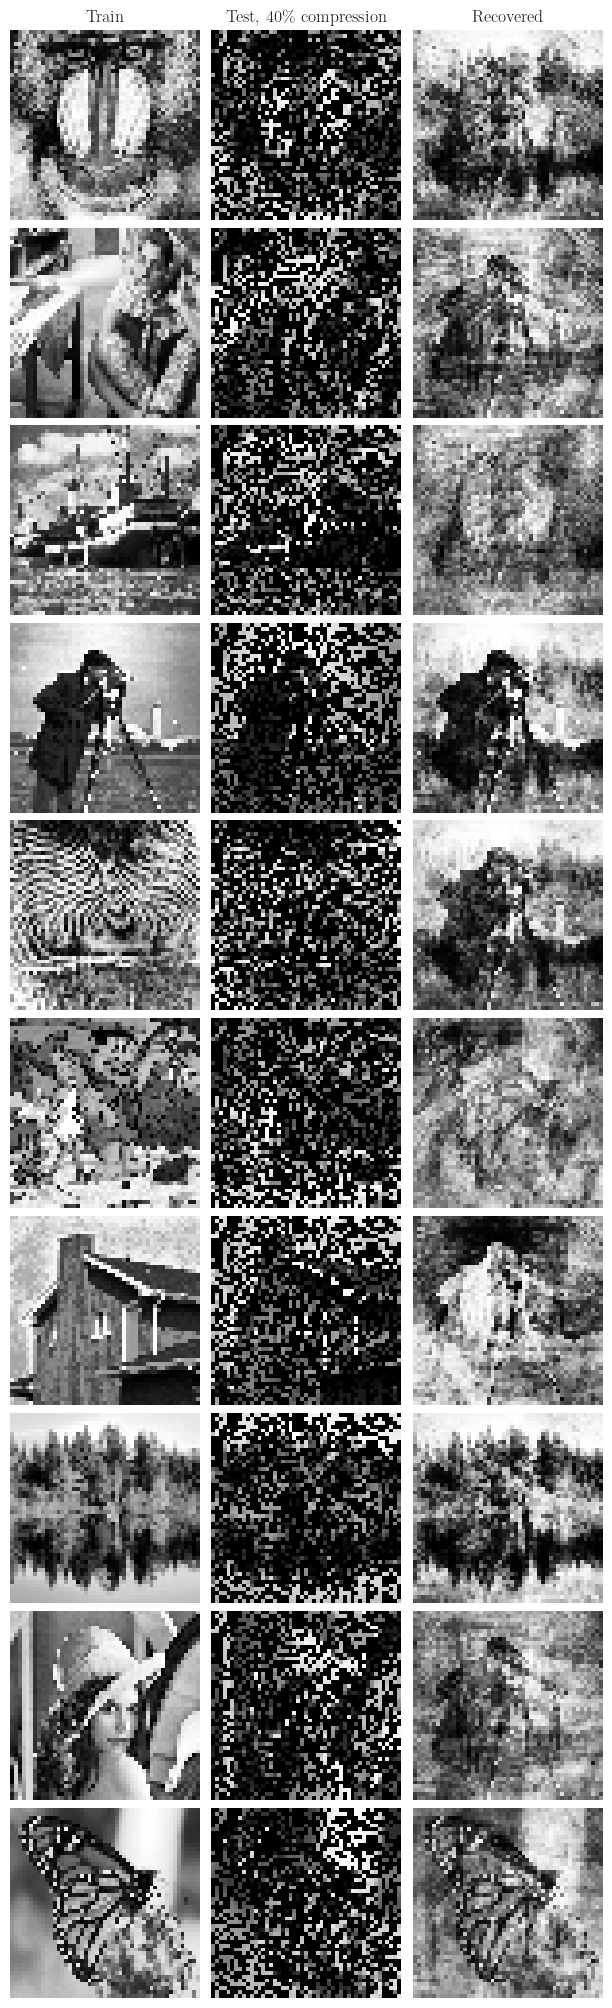

loss = 8828.07421875 
 psnr = 13.104941368103027 
 ssim = 0.5225644707679749


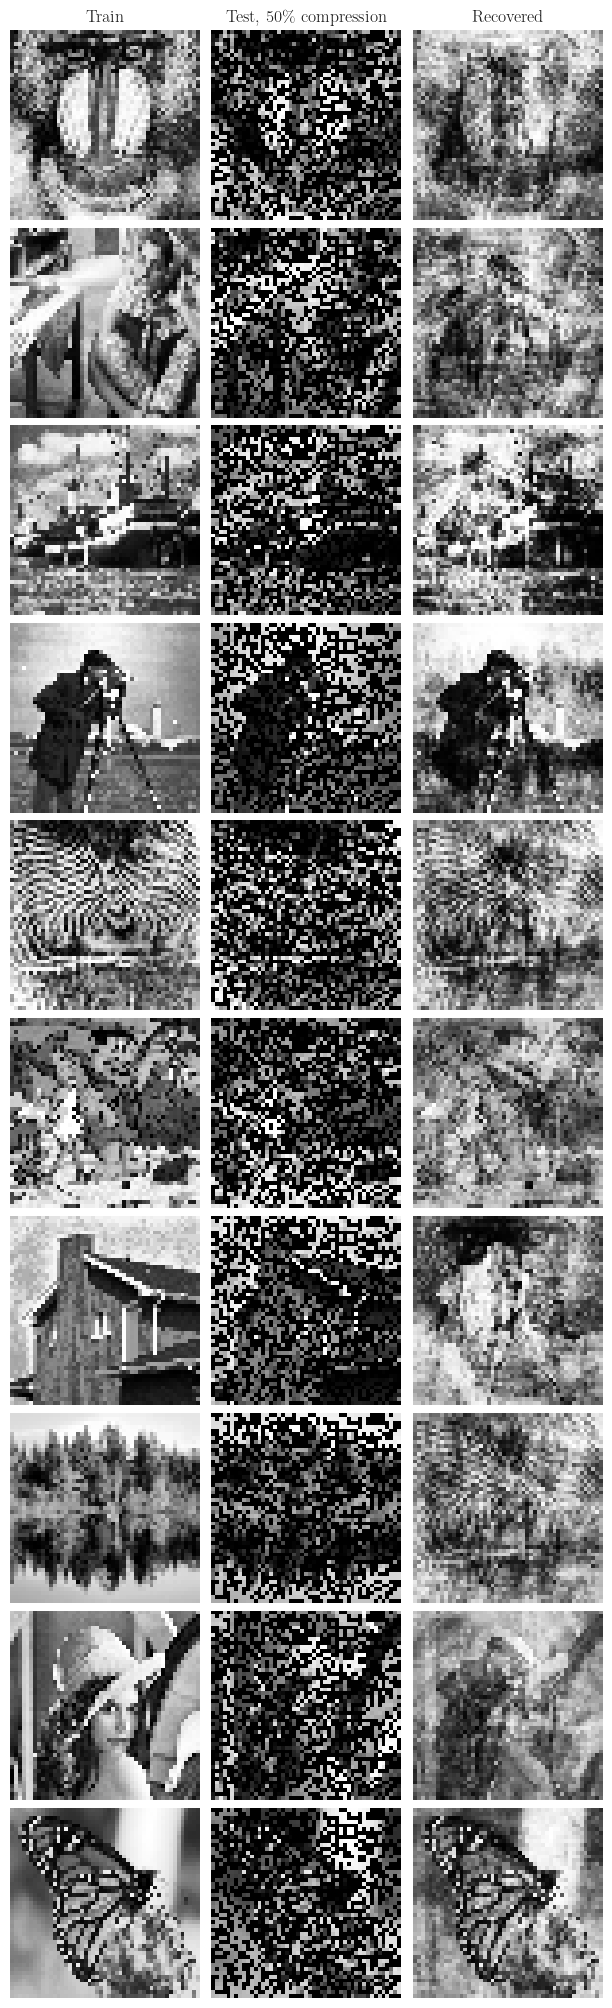

loss = 3154.65380859375 
 psnr = 17.86919403076172 
 ssim = 0.7901414036750793


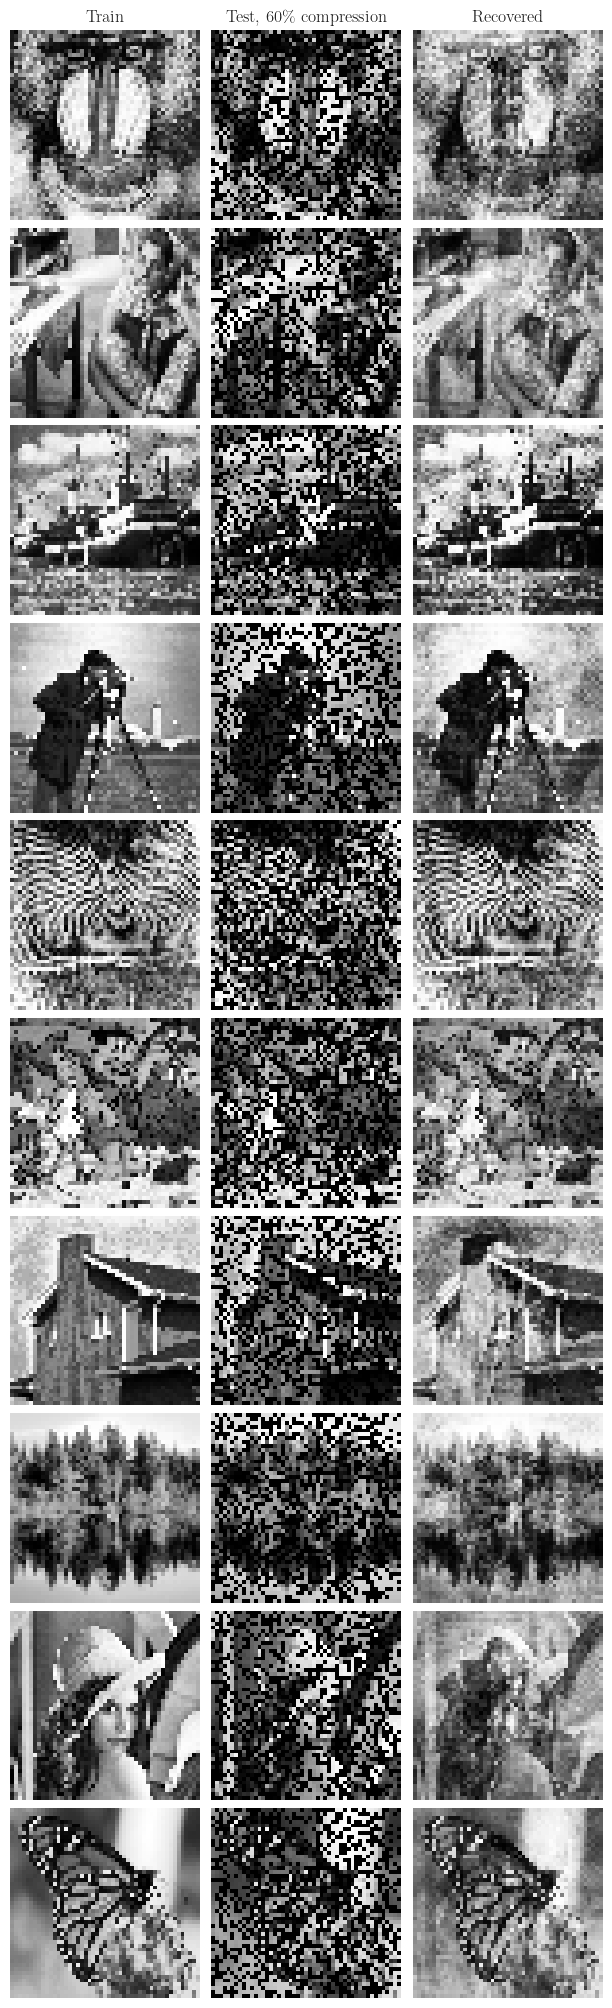

loss = 2029.769287109375 
 psnr = 20.033021926879883 
 ssim = 0.861651599407196


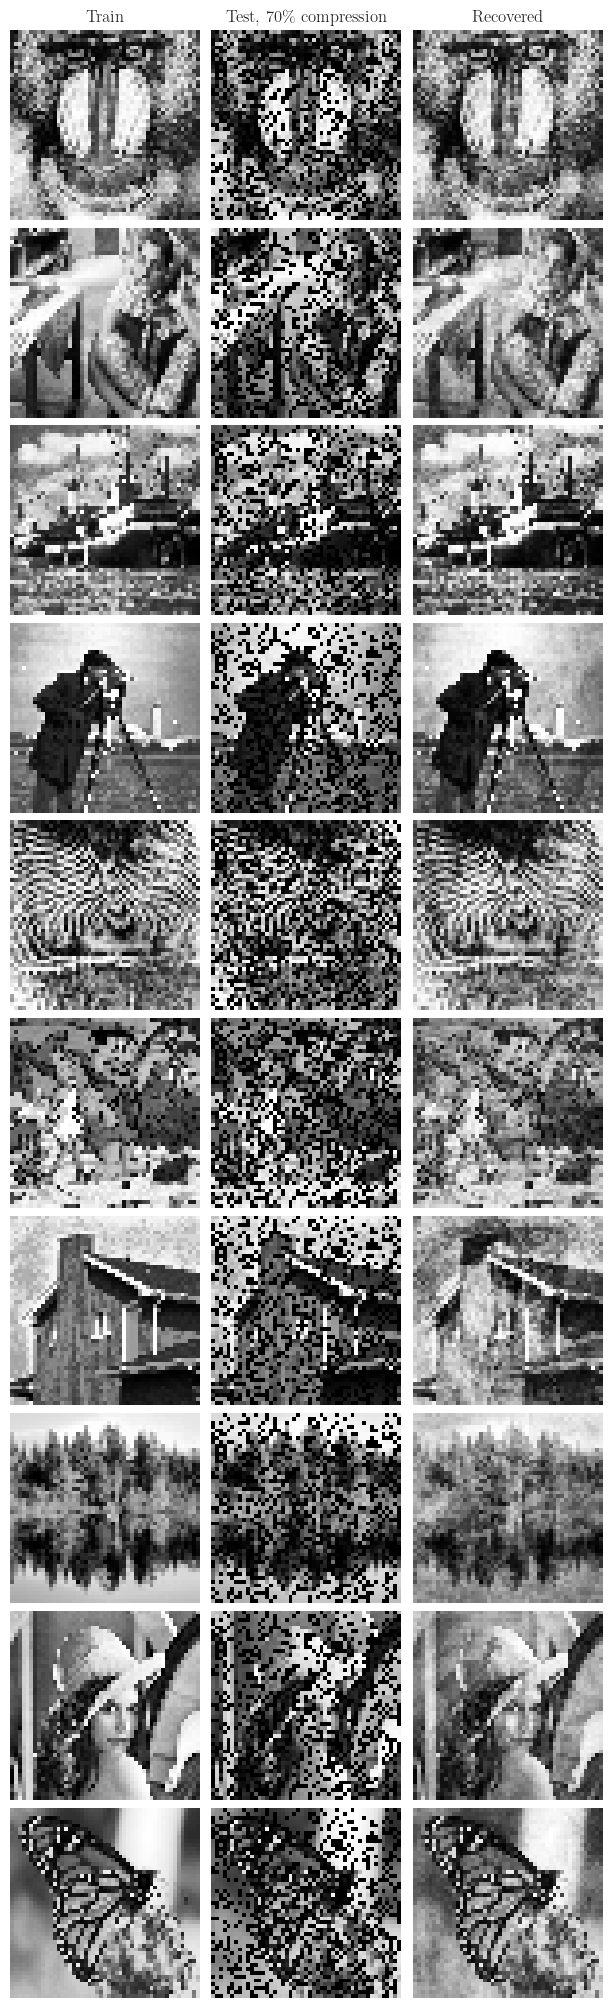

loss = 929.987060546875 
 psnr = 22.771528244018555 
 ssim = 0.9340442419052124


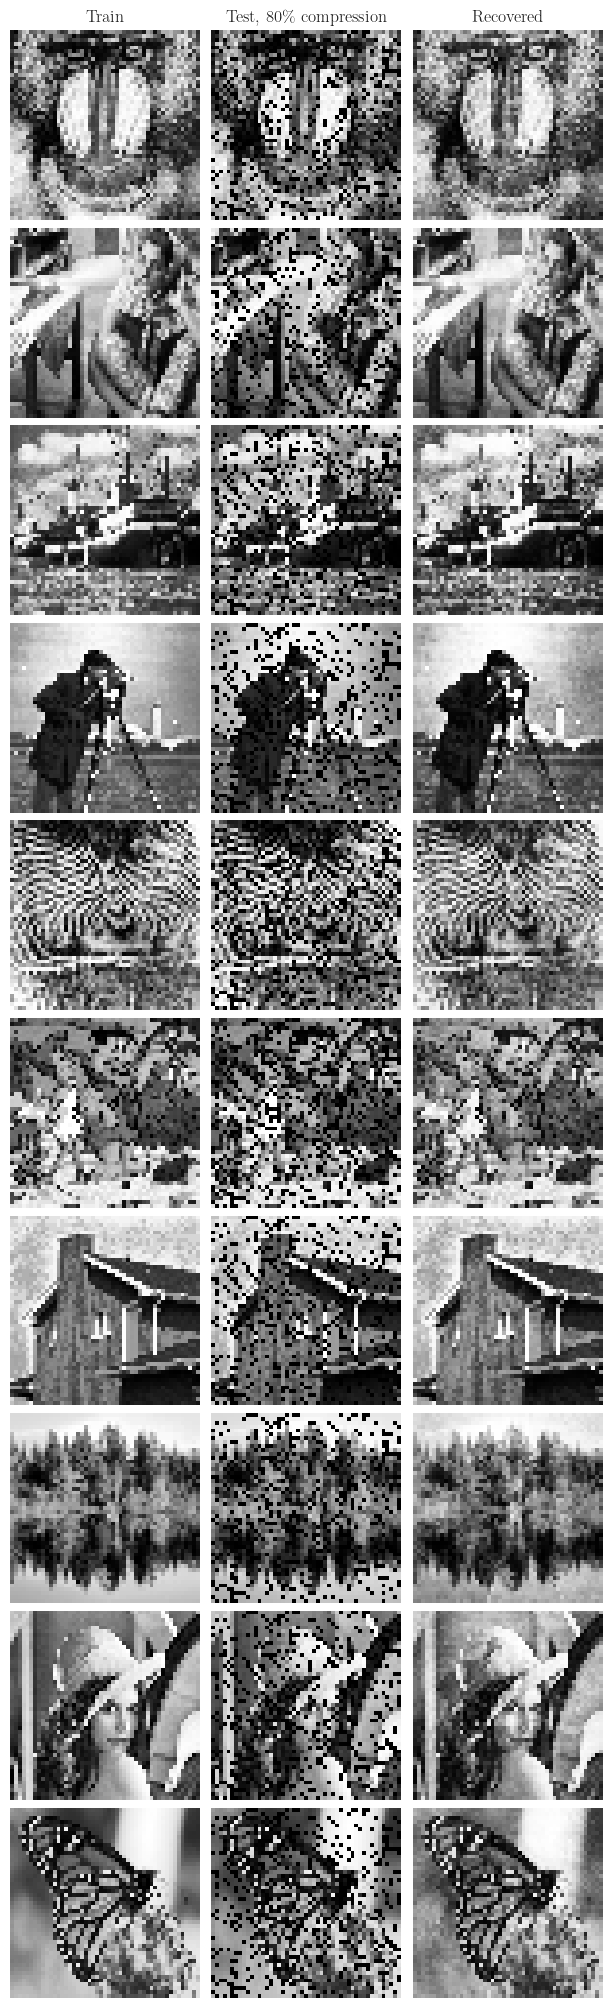

loss = 321.13470458984375 
 psnr = 28.02547836303711 
 ssim = 0.9755908846855164


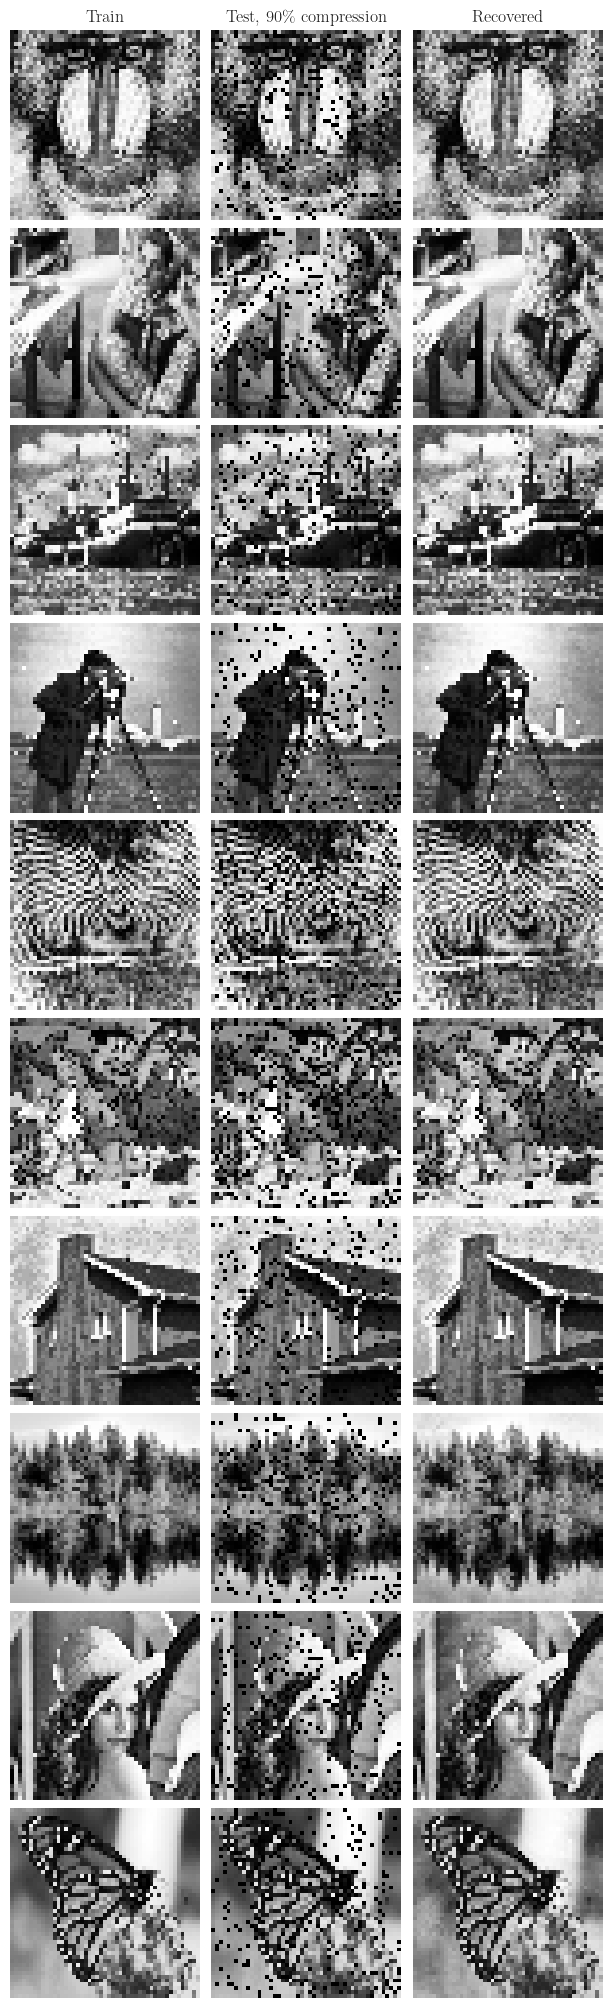

loss = 0.873223602771759 
 psnr = 52.17812728881836 
 ssim = 0.9999287724494934


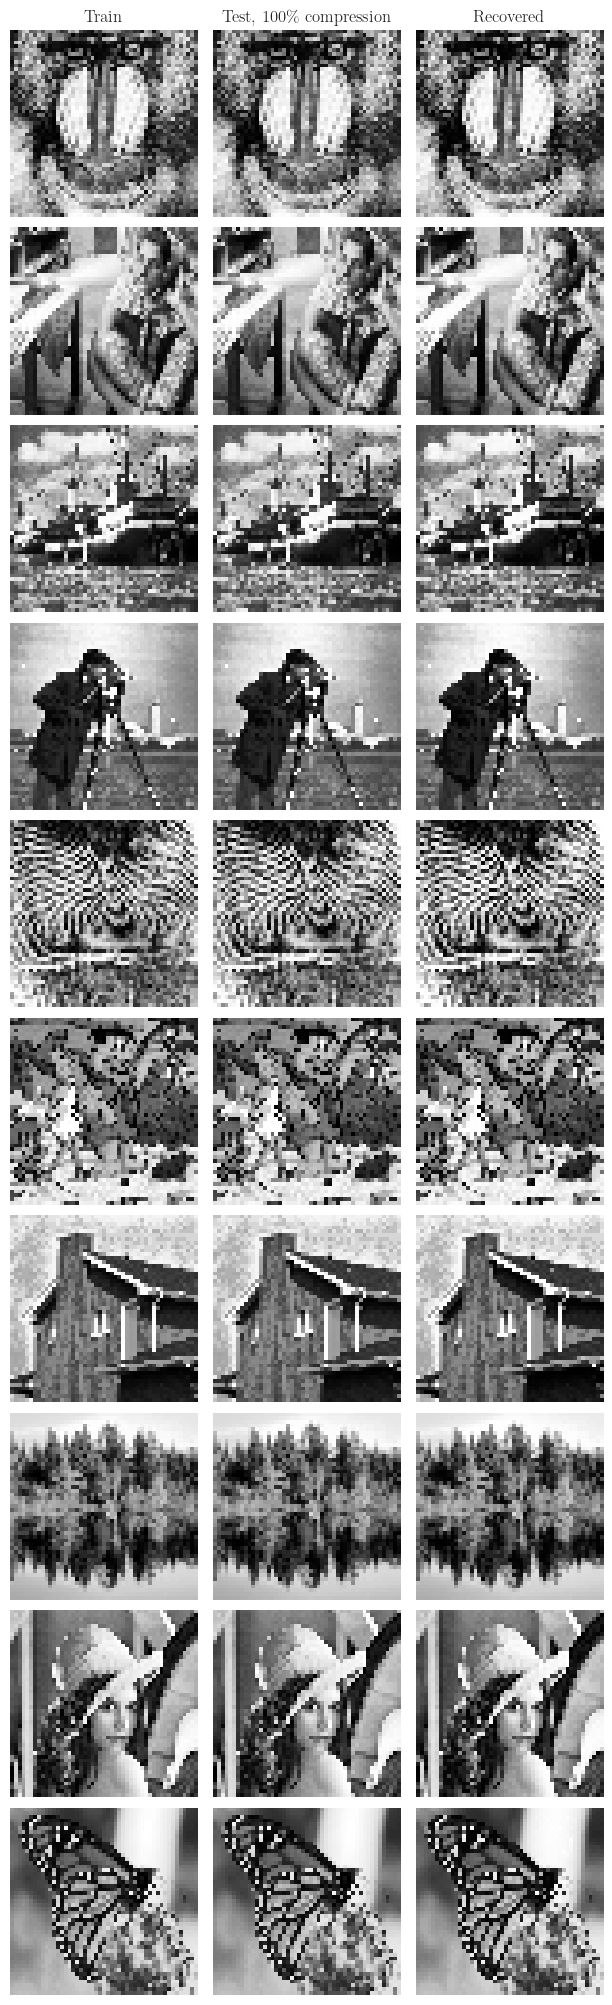

In [16]:
for p in np.concatenate(([0.01], np.arange(0.0, 1.1, 0.1))):
    mask = rand.choice([0, 1], size=(img_h, img_w, 1), p=[1-p, p])
    x_test = np.array([x_train0[i]*mask for i in range(len(x_train0))])

    rec = amrnn.predict(x_test/255)
    rec = (rec*255).astype('uint8')
    met = amrnn.test_on_batch(x_train0/255, rec/255)

    print('loss = {} \n psnr = {} \n ssim = {}'.format(*met))

    fig, ax = mp.subplots(cap, 3, figsize=(6, cap*2))
#     ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title('Test, {}\% compression'.format(int(p*100)))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

    mp.savefig(sessiondir + '%ipx_%iinputs_%ipcratio.png' \
                             %(img_w, cap, int(p*100)),
               dpi=300,
               bbox_inches='tight',
               transparent=True)
    mp.grid(False)
    mp.tight_layout(pad=0.2)
    mp.show()

In [17]:
mask25occ = np.ones_like(x_train0[0])
L = len(mask25occ)
mask25occ[L//2:, L//2:] = 0

mask50occ = np.ones_like(x_train0[0])
L = len(mask50occ)
mask50occ[:, L//2:] = 0

mask75occ = np.ones_like(x_train0[0])
L = len(mask75occ)
mask75occ[L//2:] = 0
mask75occ[:, L//2:] = 0

maskboxocc = np.ones_like(x_train0[0])
L = len(maskboxocc)
maskboxocc[L//2-16:L//2+16, L//2-16:L//2+16] = 0

maskborderocc = np.ones_like(x_train0[0])
L = len(maskborderocc)
maskborderocc[:, :8] = 0
maskborderocc[:, -8:] = 0
maskborderocc[:8, :] = 0
maskborderocc[-8:, :] = 0

masks = [mask25occ, mask50occ, mask75occ, maskboxocc, maskborderocc]
masknames = ['occ25pc', 'occ50pc', 'occ75pc', 'occbox', 'occborder']

loss = 22518.5234375 
 psnr = 8.566483497619629 
 ssim = 0.16899600625038147


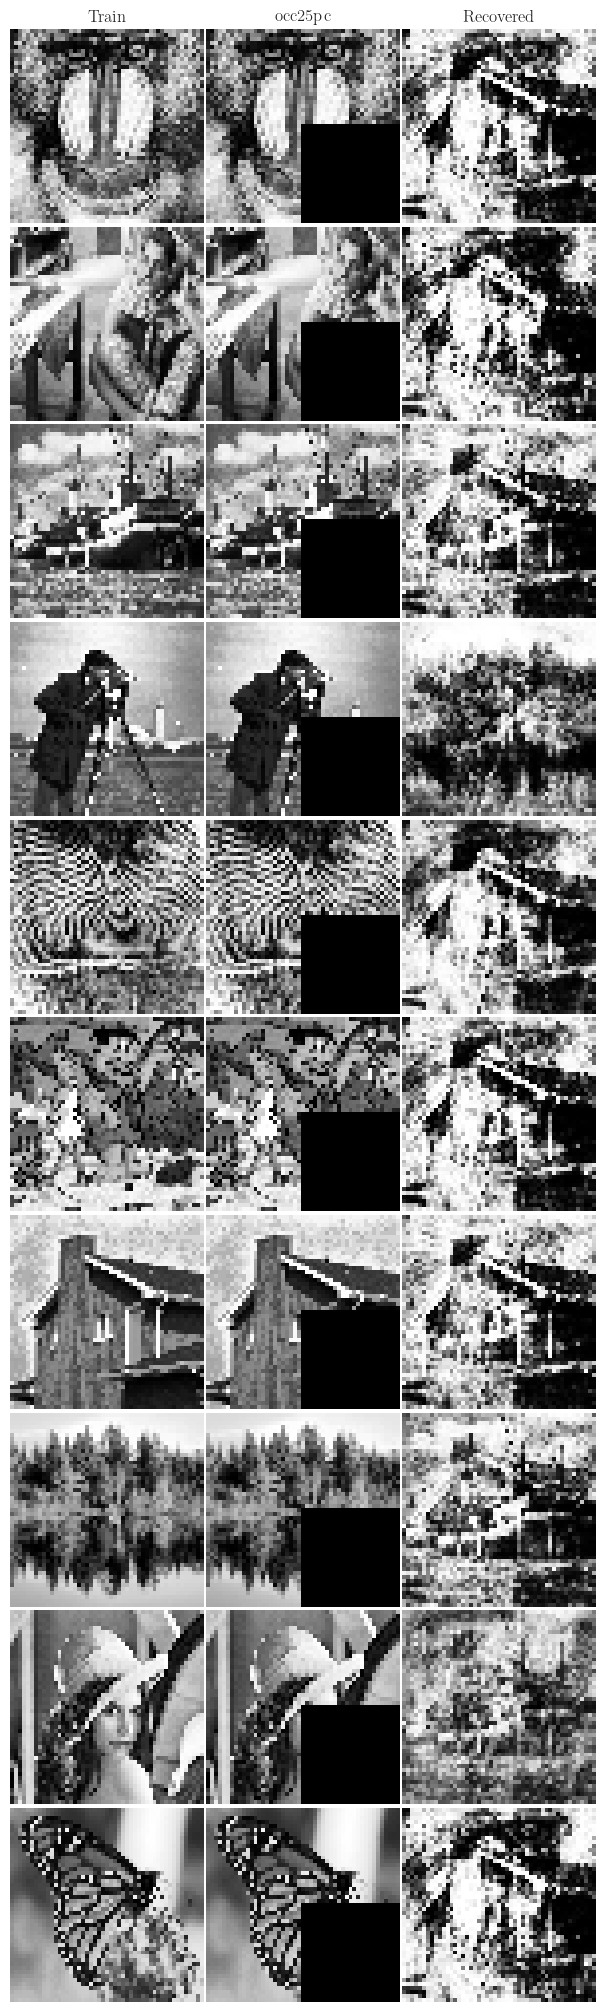

loss = 27165.25390625 
 psnr = 7.462533473968506 
 ssim = 0.10243681073188782


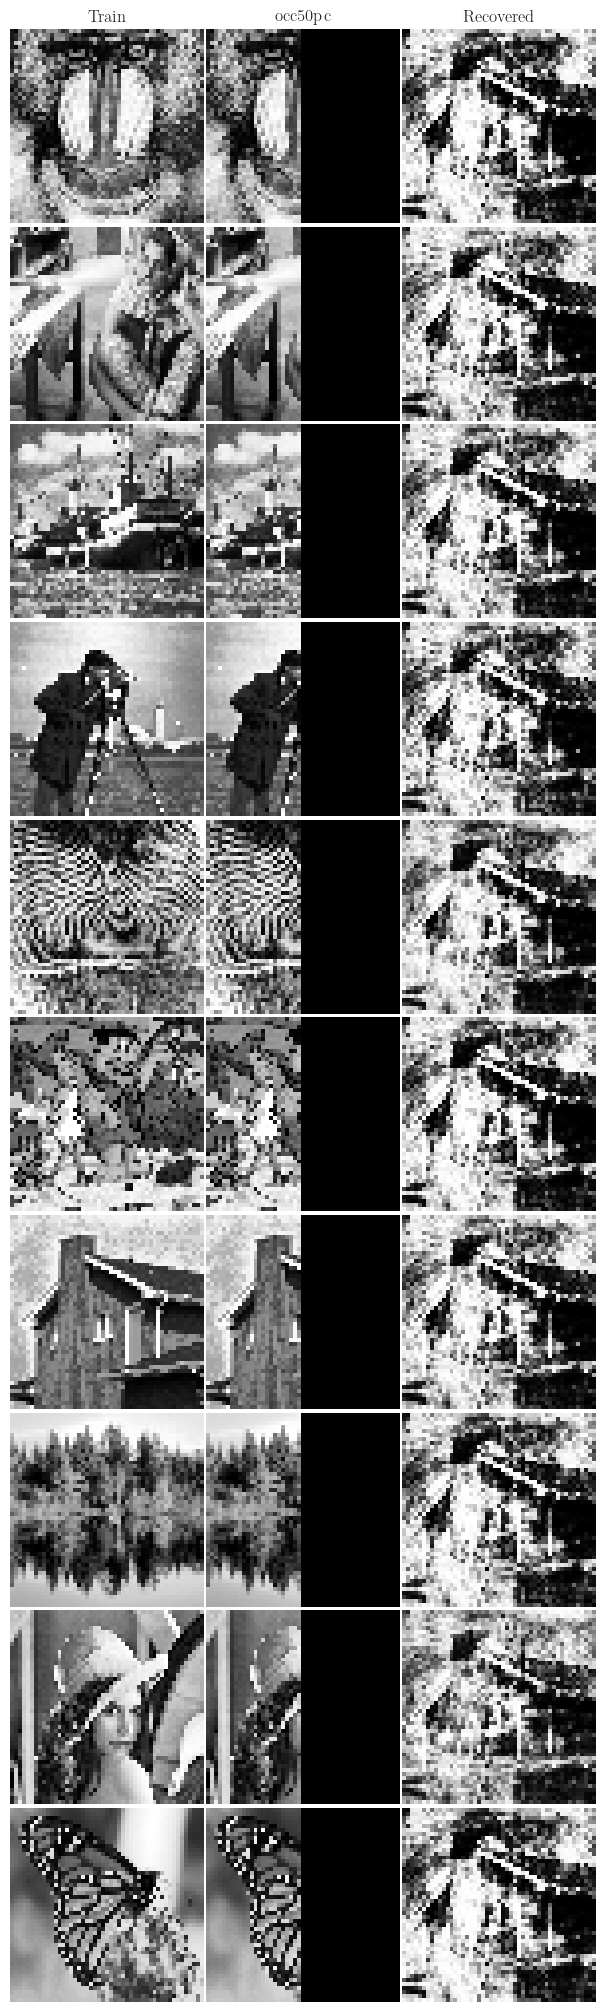

loss = 26807.228515625 
 psnr = 7.5933146476745605 
 ssim = 0.028074782341718674


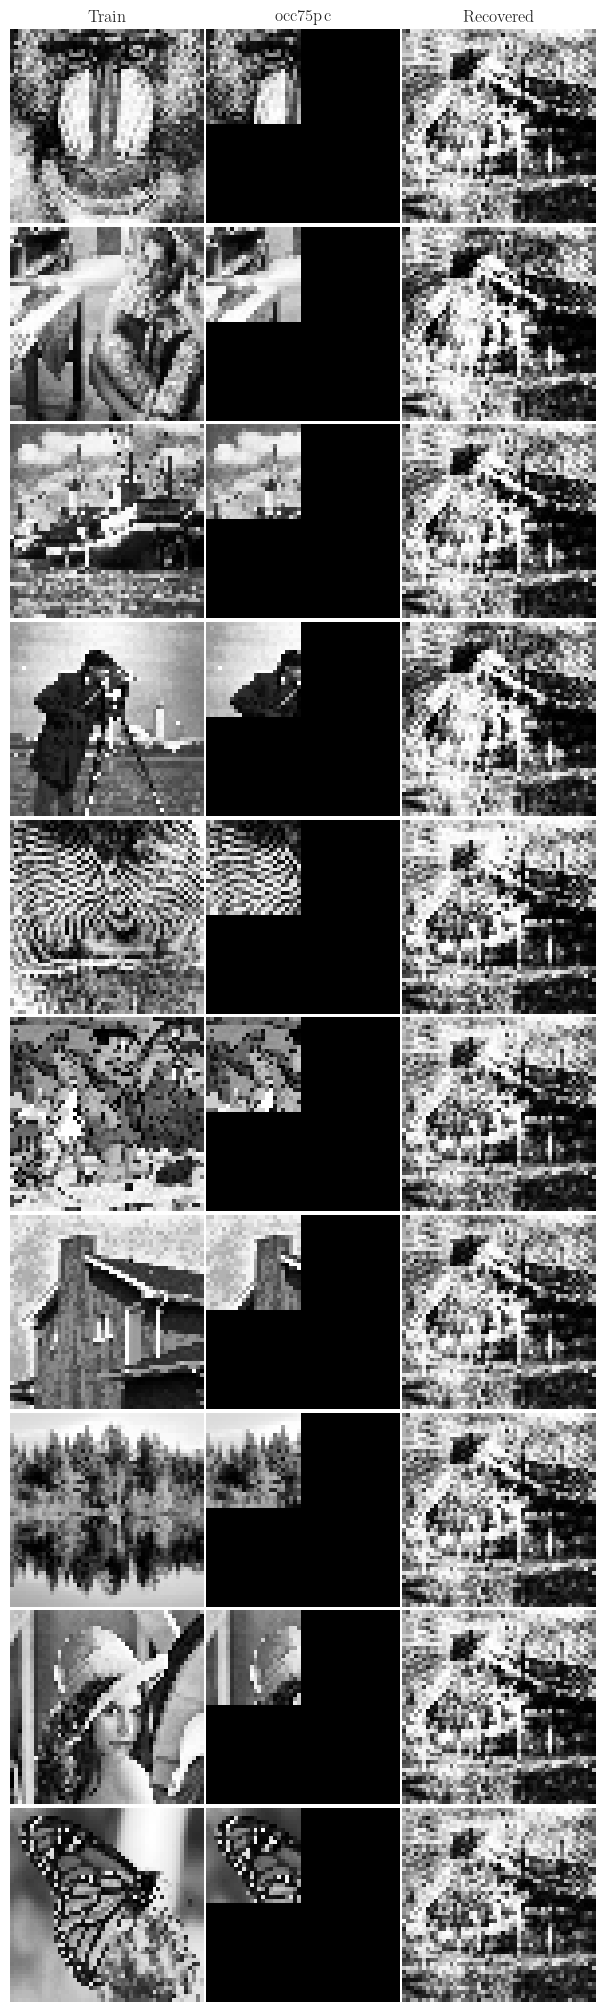

loss = 3398.8427734375 
 psnr = 18.249378204345703 
 ssim = 0.7761277556419373


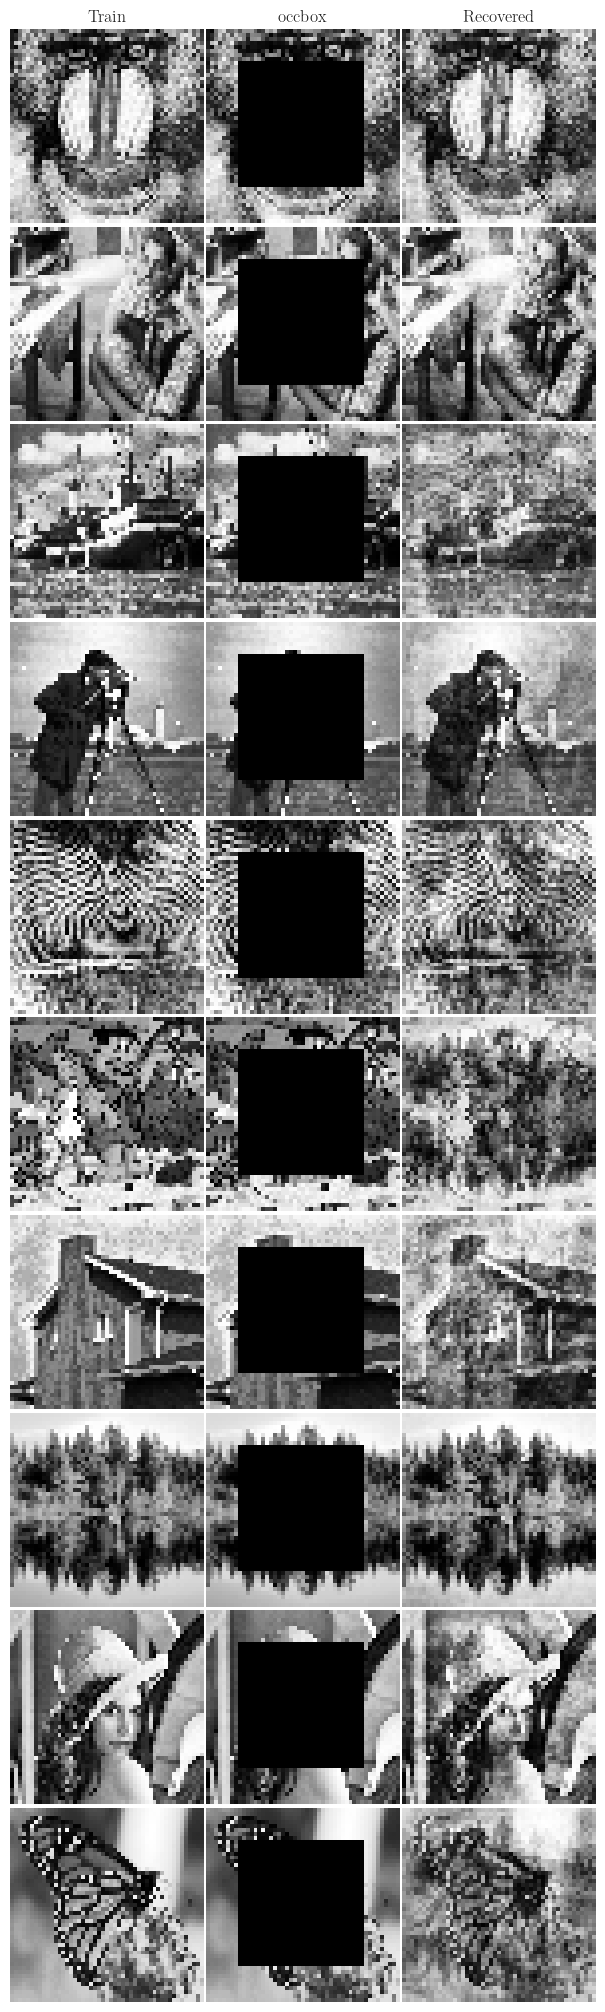

loss = 18055.955078125 
 psnr = 9.443902969360352 
 ssim = 0.16021175682544708


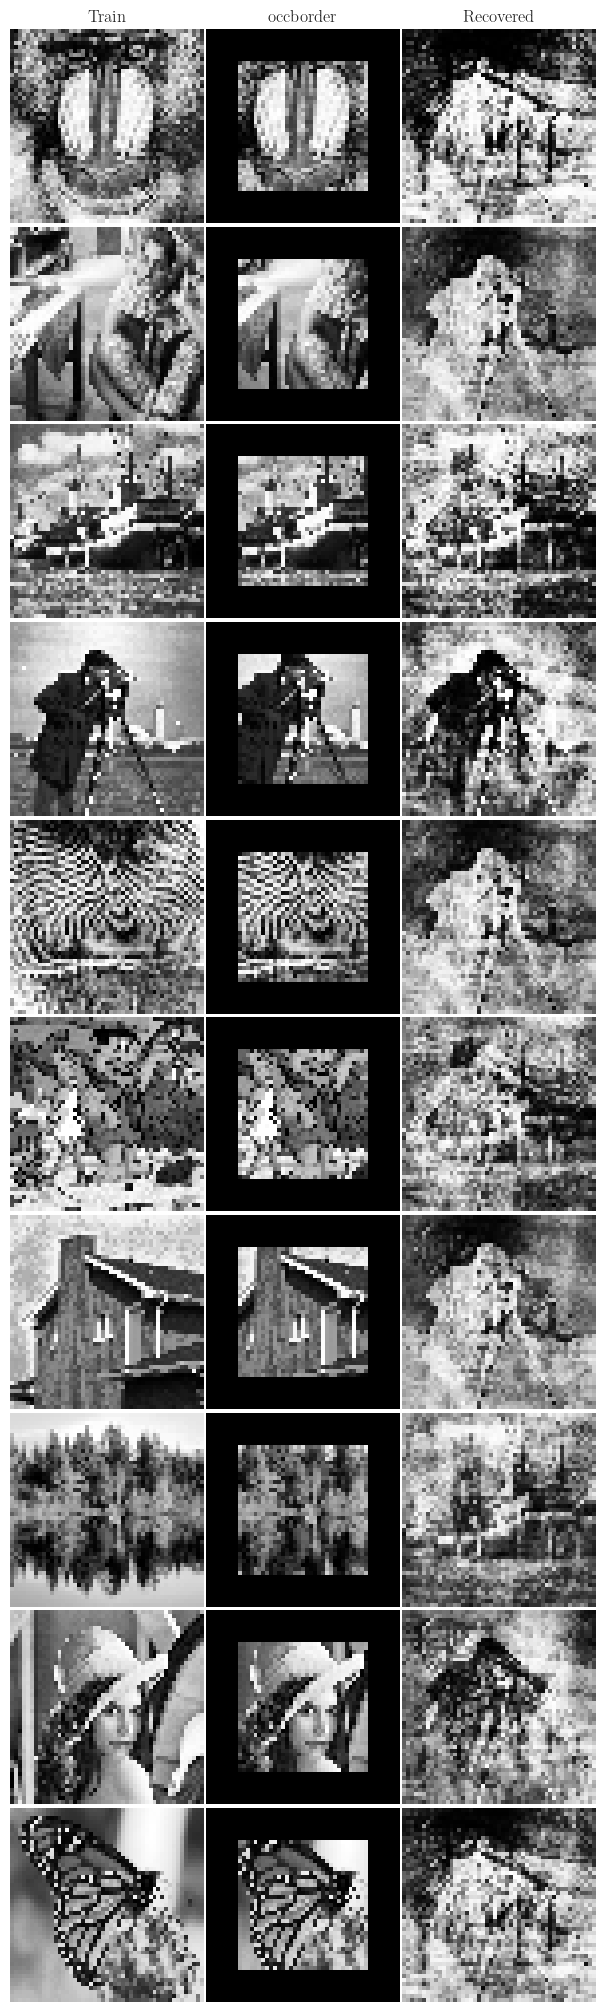

In [18]:
for m, n in zip(masks, masknames):
    x_test = np.array([x_train0[i]*m for i in range(len(x_train0))])

    rec = amrnn.predict(x_test/255)
    rec = (rec*255).astype('uint8')
    met = amrnn.test_on_batch(x_train0/255, rec/255)

    print('loss = {} \n psnr = {} \n ssim = {}'.format(*met))

    fig, ax = mp.subplots(cap, 3, figsize=(6, cap*2))
    #     ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title(n)
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

    mp.savefig(sessiondir + str(img_w) + 'px_' + str(cap) + 'inputs' + n + '.png',
               dpi=300,
               bbox_inches='tight',
               transparent=True)
    mp.grid(False)
    mp.tight_layout(pad=0.2)
    mp.show()